# CIFAR-10

CIFAR-10 dataset: http://www.cs.toronto.edu/~kriz/cifar.html\

#### Cieľ zadania: Klasifikácia obrázku jednej z nasledujúcich tried:
• 0: airplane\
• 1: automobile\
• 2: bird\
• 3: cat\
• 4: deer\
• 5: dog\
• 6: frog\
• 7: horse\
• 8: ship\
• 9: truck

In [11]:
from matplotlib import pyplot
from keras.datasets import cifar10

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

import wandb
from wandb.keras import WandbCallback

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [3]:
def countValues(data):
    unique_vals, counts = np.unique(data, return_counts=True)

    for val, count in zip(unique_vals, counts):
        print("Value {}: {} occurrences".format(val, count))

In [4]:
import numpy as np
from keras.datasets import cifar10

# Load the CIFAR-10 dataset
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

import numpy as np
from sklearn.model_selection import train_test_split

# Split X_test and y_test into validation and testing subsets
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

print('Train: X=%s, y=%s' % (X_train.shape, y_train.shape))
print('Test: X=%s, y=%s' % (X_val.shape, y_val.shape))

Train: X=(50000, 32, 32, 3), y=(50000, 1)
Test: X=(5000, 32, 32, 3), y=(5000, 1)


In [5]:
countValues(y_train)

Value 0: 5000 occurrences
Value 1: 5000 occurrences
Value 2: 5000 occurrences
Value 3: 5000 occurrences
Value 4: 5000 occurrences
Value 5: 5000 occurrences
Value 6: 5000 occurrences
Value 7: 5000 occurrences
Value 8: 5000 occurrences
Value 9: 5000 occurrences


In [6]:
countValues(y_val)

Value 0: 521 occurrences
Value 1: 514 occurrences
Value 2: 475 occurrences
Value 3: 500 occurrences
Value 4: 494 occurrences
Value 5: 522 occurrences
Value 6: 489 occurrences
Value 7: 472 occurrences
Value 8: 511 occurrences
Value 9: 502 occurrences


### Dáta:
• RGB obrázky v rozmeroch 32x32x3\
• obrázky rozdelené do 10 tried\
Trénovacích vzoriek: 50000 - každá trieda má 5000 vzoriek\
Testovacích vzoriek: 10000 - každá trieda má 1000 vzoriek

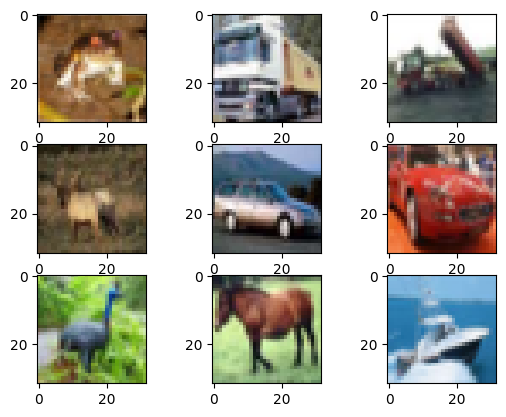

In [7]:
for i in range(9):
    pyplot.subplot(330 + 1 + i)
    pyplot.imshow(X_train[i])

pyplot.show()

In [8]:
print('Class:')
for i in range(9):
    print(y_train[i])

Class:
[6]
[9]
[9]
[4]
[1]
[1]
[2]
[7]
[8]


Normalizacia dat - hodnoty pixelov jednotlivych obrazkov stlacime do intervalu 0 - 1.\
Better gradient propagation - stability of gradient \
Faster convergence - because normalization can help to reduce the scale difference between features \
Robustness to input variations - network can be made more invariant to variations in lighting, contrast, and other image properties

In [9]:
# Convert pixel values to float type
X_train = X_train.astype('float32')
X_val = X_val.astype('float32')
X_test = X_test.astype('float32')


# Normalize pixel values to the range 0-1
X_train /= 255.0
X_val /= 255.0
X_test /= 255.0

Augmentacia dat, zvysenie poctu obrazkov o dvojnasobok

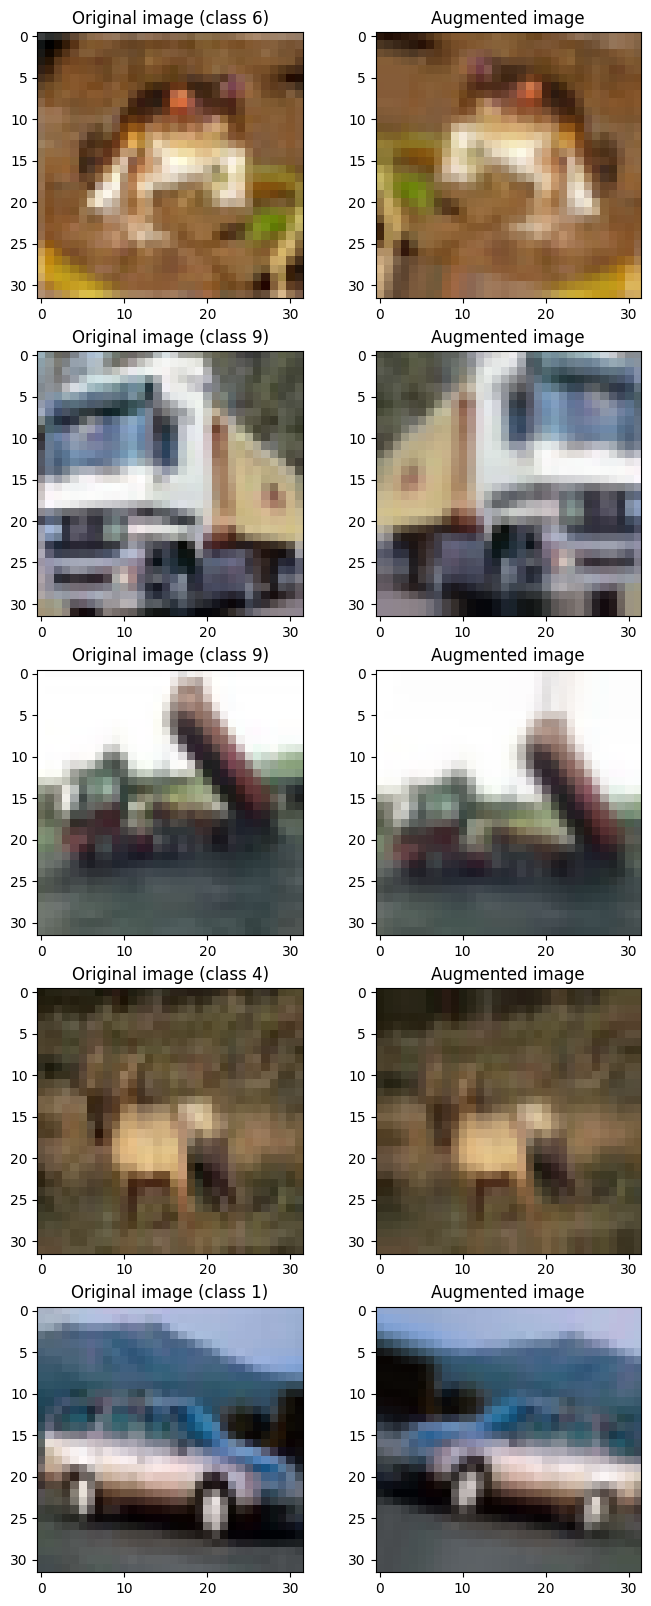

In [12]:
# Define the data augmentation generator
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    zoom_range=0.1)

# Generate augmented images and labels
augmented_images = []
augmented_labels = []
for i in range(X_train.shape[0]):
    # Generate augmented image
    augmented_image = datagen.random_transform(X_train[i])
    # Append augmented image to list of augmented images
    augmented_images.append(augmented_image)
    # Append corresponding label to list of augmented labels
    augmented_labels.append(y_train[i])

# Convert the list of augmented images and labels to numpy arrays
augmented_images = np.array(augmented_images)
augmented_labels = np.array(augmented_labels)

# Concatenate original images and labels with augmented images and labels
X_train = np.concatenate((X_train, augmented_images))
y_train = np.concatenate((y_train, augmented_labels))

# Plot the original and augmented images
fig, axes = plt.subplots(5, 2, figsize=(8, 20))
for i in range(5):
    # Plot the original image
    axes[i, 0].imshow(X_train[i])
    axes[i, 0].set_title(f"Original image (class {y_train[i][0]})")

    # Plot the augmented image
    axes[i, 1].imshow(augmented_images[i])
    axes[i, 1].set_title("Augmented image")
plt.show()

In [13]:
print(X_train.shape)
print(y_train.shape)

(100000, 32, 32, 3)
(100000, 1)


In [16]:
# one hot encode target values
trainY = tf.keras.utils.to_categorical(y_train)
testY = tf.keras.utils.to_categorical(y_val)

In [19]:
print(testY[1])

[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]


In [20]:
print(y_val[1])

[8]


In [71]:
# Define the CNN model
model = keras.Sequential([
    layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(32, 32, 3)),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dense(10, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val))

Epoch 1/10
1563/1563 [==============================] - 55s 34ms/step - loss: 2.8004 - accuracy: 0.1793 - val_loss: 1.8881 - val_accuracy: 0.2854
Epoch 2/10
1563/1563 [==============================] - 53s 34ms/step - loss: 1.7541 - accuracy: 0.3519 - val_loss: 1.5284 - val_accuracy: 0.4439
Epoch 3/10
1563/1563 [==============================] - 55s 35ms/step - loss: 1.4038 - accuracy: 0.5014 - val_loss: 1.3334 - val_accuracy: 0.5242
Epoch 4/10
1563/1563 [==============================] - 56s 36ms/step - loss: 1.1654 - accuracy: 0.5917 - val_loss: 1.2357 - val_accuracy: 0.5778
Epoch 5/10
1563/1563 [==============================] - 59s 37ms/step - loss: 0.9728 - accuracy: 0.6622 - val_loss: 1.2019 - val_accuracy: 0.5886
Epoch 6/10
1563/1563 [==============================] - 56s 36ms/step - loss: 0.8064 - accuracy: 0.7220 - val_loss: 1.2680 - val_accuracy: 0.6025
Epoch 7/10
1563/1563 [==============================] - 56s 36ms/step - loss: 0.6510 - accuracy: 0.7777 - val_loss: 1.4175 -

Augmentovany a normalizovany dataset

In [14]:
# Define the CNN model
model = keras.Sequential([
    layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(32, 32, 3)),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dense(10, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [15]:
model.fit(X_train, y_train, epochs=5, validation_data=(X_val, y_val))

Epoch 1/5
3125/3125 [==============================] - 83s 26ms/step - loss: 1.2843 - accuracy: 0.5422 - val_loss: 1.0184 - val_accuracy: 0.6370
Epoch 2/5
3125/3125 [==============================] - 82s 26ms/step - loss: 0.9358 - accuracy: 0.6716 - val_loss: 0.8813 - val_accuracy: 0.6988
Epoch 3/5
3125/3125 [==============================] - 86s 28ms/step - loss: 0.7585 - accuracy: 0.7354 - val_loss: 0.8406 - val_accuracy: 0.7136
Epoch 4/5
3125/3125 [==============================] - 85s 27ms/step - loss: 0.6079 - accuracy: 0.7882 - val_loss: 0.8523 - val_accuracy: 0.7286
Epoch 5/5
3125/3125 [==============================] - 84s 27ms/step - loss: 0.4725 - accuracy: 0.8332 - val_loss: 0.8959 - val_accuracy: 0.7248
